# Imports

In [2]:
import blocksnet as bn
%matplotlib inline
from shapely.geometry import Point
from geopandas import GeoDataFrame
from blocksnet.models.land_use import LandUse

# Model

Читаем модель

In [3]:
city = bn.City.from_pickle(
    r'C:\Users\rkozl\Desktop\BlocksNet\blocksnet\new_model.pickle')

Выбираем квартал который хотим менять и выбираем новое землепользование для него

In [4]:
selected_block_id = 104
selected_block = city[selected_block_id]
orig_landuse = selected_block.land_use
new_landuse = LandUse.TRANSPORT

Обрезаем область вокруг выбранного квартала для просчета обеспеченности не на всем городе

In [5]:
centroid_radius = 1000
centroid = city.get_blocks_gdf(True).loc[selected_block_id]['geometry'].centroid
x, y = int(centroid.x), int(centroid.y)
poly_gdf = GeoDataFrame([{"geometry": Point(x, y).buffer(centroid_radius), "value1": x + y, "value2": x - y}])

In [6]:
orig_blocks = city.get_blocks_gdf()
blocks_clipped = orig_blocks.clip(poly_gdf)

c:\Users\rkozl\Desktop\BlocksNet\blocksnet\.venv\Lib\site-packages\geopandas\geodataframe.py:2362: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32636
Right CRS: None

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type)


In [7]:
new_blocks = {}
for idx in blocks_clipped.index:
    new_blocks[idx] = city._blocks[idx]

In [8]:
adj_matrix = city.adjacency_matrix
adj_matrix = adj_matrix[blocks_clipped.index].iloc[blocks_clipped.index]

In [9]:
city._blocks = new_blocks
city.adjacency_matrix = adj_matrix

# Optimizer

Инициализируем класс для подбора оптимальной застройки сервисов в соответсвии с выбранным землепользование

In [10]:
from blocksnet.method.block_optimizer.PULP_optimizer import Pulp_Optimizer

opt = Pulp_Optimizer(city_model=city)
result, deleting_update_df = opt.calculate(selected_block=selected_block, new_landuse=new_landuse)

Метод выдает оптимальные типы сервисов и их вместимость

In [11]:
result['optimal_update_df']

,fuel,police
104,120,5280


Также можно узнать какие сервисы были снесены перед постройкой новых

In [12]:
deleting_update_df

,park,kindergarten,pharmacy,bank,hairdresser,hotel,bakery,convenience,cafe,religion,police,population
104,-197,-280,-31,-109,-10,-1513,-369,-456,-387,-2537,-5,-1357


С помощью метода plot мы можем отобразить гистограмму изменений в в квартале по сравнению с оригинальной застройкой

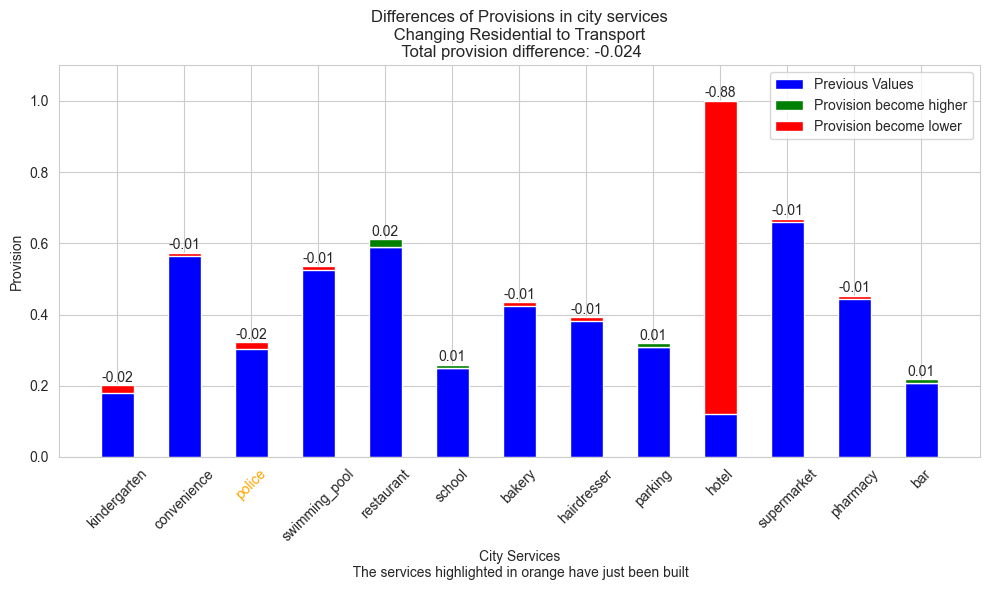

In [13]:
opt.plot(**result)

Также можно выбрать оптимальное землепользование использовав метод для всех возможных типов землепользования

In [14]:
best_landuse = selected_block.land_use
temp_diff = 0
for lanuse in LandUse:
    if lanuse == orig_landuse:
        continue
    result = opt.calculate(selected_block=selected_block, new_landuse=lanuse)
    diff = result['total_after'] - result['total_before']
    print(f'{selected_block.land_use} -> {lanuse}: {round(diff, 3)}')
    if diff > temp_diff:
        temp_diff = diff
        best_landuse = lanuse

print(f'best lanuse {best_landuse}')

KeyboardInterrupt: 